# Figure X.x - Retraining of a supervised 3D model with unsupervised labels
Goals : 

- Show that a 3D model retrained using the output of an unsupervised model can perform similarly than a model trained on ground truth labels.

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ██████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]

In [5]:
swin_wnet_path = DATA_PATH / "RESULTS/WNET_RETRAIN/inference"
swin_wnet_predictions = [imread(str(f)) for f in swin_wnet_path.glob("*.tif")]
swin_wnet_predictions.reverse()

## Computations

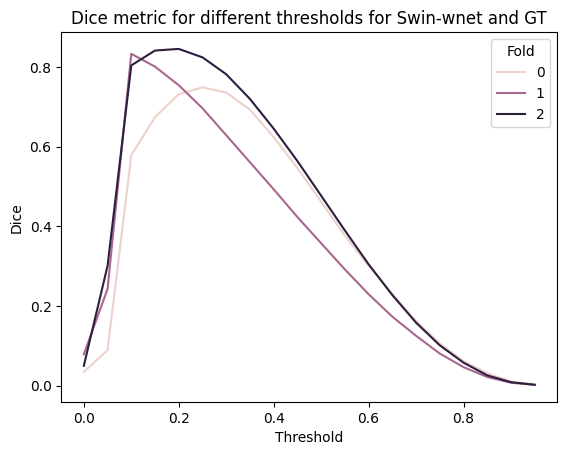

In [6]:
# plot dice metric for several thresholds for swin-wnet and GT using a dataframe that records which threshold and fold the dice was calculated for
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, swin_wnet_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin-wnet and GT")
plt.show()

In [7]:
swin_thresholded = [np.where(swin > 0.5, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.45, segresnet, 0) for segresnet in segresnet_predictions]
swin_wnet_thresholded = [np.where(wnet > 0.2, wnet, 0) for wnet in swin_wnet_predictions]

In [8]:
swin_instance = []
segresnet_instance = []
swin_wnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )
    swin_wnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_wnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                             )

In [9]:
# from tifffile import imwrite
# for i in range(len(fold_paths)):
#     save_folder = data_path / "processed" / f"fold{i+1}"
#     save_folder.mkdir(exist_ok=True, parents=False)
#     imwrite(save_folder / "swin_instance.tif", swin_instance[i])
#     imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [10]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   swin_instance,
   segresnet_instance,
#    cellpose_predictions,
#    stardist_predictions,
   swin_wnet_instance
   ]
names = ["SwinUNetR",
         "SegResNet",
        #  "Cellpose",
        #  "Stardist",
         "Swin (WNet labels)"
         ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        stats = [matching_dataset(
            GT_labels[j], p[j], thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on SwinUNetR
********************
Validating on SegResNet
********************
Validating on Swin (WNet labels)
********************
Fold  2
Validating on SwinUNetR
********************
Validating on SegResNet
********************
Validating on Swin (WNet labels)
********************
Fold  3
Validating on SwinUNetR
********************
Validating on SegResNet
********************
Validating on Swin (WNet labels)
********************


In [11]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision  \
Model              Fold thresh                                          
SwinUNetR          1    0.1          iou   221  2793   592   0.926676   
                        0.2          iou   248  2766   619   0.917717   
                        0.3          iou   312  2702   683   0.896483   
                        0.4          iou   379  2635   750   0.874253   
                        0.5          iou   479  2535   850   0.841075   
...                                  ...   ...   ...   ...        ...   
Swin (WNet labels) 3    0.5          iou   924  4620  2289   0.833333   
                        0.6          iou  1434  4110  2799   0.741342   
                        0.7          iou  2046  3498  3411   0.630952   
                        0.8          iou  2981  2563  4346   0.462302   
                        0.9          iou  4309  1235  5674   0.222763   

                                  recall  accuracy        f1  n_true  n_pred  \
Model              Fold thresh                                                 
SwinUNetR          1    0.1     0.825111  0.774542  0.872949    3385    3014   
                        0.2     0.817134  0.761354  0.864510    3385    3014   
                        0.3     0.798227  0.730863  0.844507    3385    3014   
                        0.4     0.778434  0.700053  0.823566    3385    3014   
                        0.5     0.748892  0.656056  0.792311    3385    3014   
...                                  ...       ...       ...     ...     ...   
Swin (WNet labels) 3    0.5     0.668693  0.589812  0.741990    6909    5544   
                        0.6     0.594876  0.492629  0.660082    6909    5544   
                        0.7     0.506296  0.390620  0.561792    6909    5544   
                        0.8     0.370965  0.259151  0.411628    6909    5544   
                        0.9     0.178752  0.110091  0.198346    6909    5544   

                                mean_true_score  mean_matched_score  \
Model              Fold thresh                                        
SwinUNetR          1    0.1            0.614096            0.744259   
                        0.2            0.613144            0.750359   
                        0.3            0.608406            0.762196   
                        0.4            0.601647            0.772894   
                        0.5            0.588905            0.786368   
...                                         ...                 ...   
Swin (WNet labels) 3    0.5            0.533343            0.797589   
                        0.6            0.494324            0.830970   
                        0.7            0.436757            0.862651   
                        0.8            0.335545            0.904517   
                        0.9            0.173046            0.968076   

                                panoptic_quality  by_image  
Model              Fold thresh                              
SwinUNetR          1    0.1             0.649700     False  
                        0.2             0.648693     False  
                        0.3             0.643680     False  
                        0.4             0.636529     False  
                        0.5             0.623048     False  
...                                          ...       ...  
Swin (WNet labels) 3    0.5             0.591803     False  
                        0.6             0.548508     False  
                        0.7             0.484631     False  
                        0.8             0.372324     False  
                        0.9             0.192014     False  

[81 rows x 14 columns]

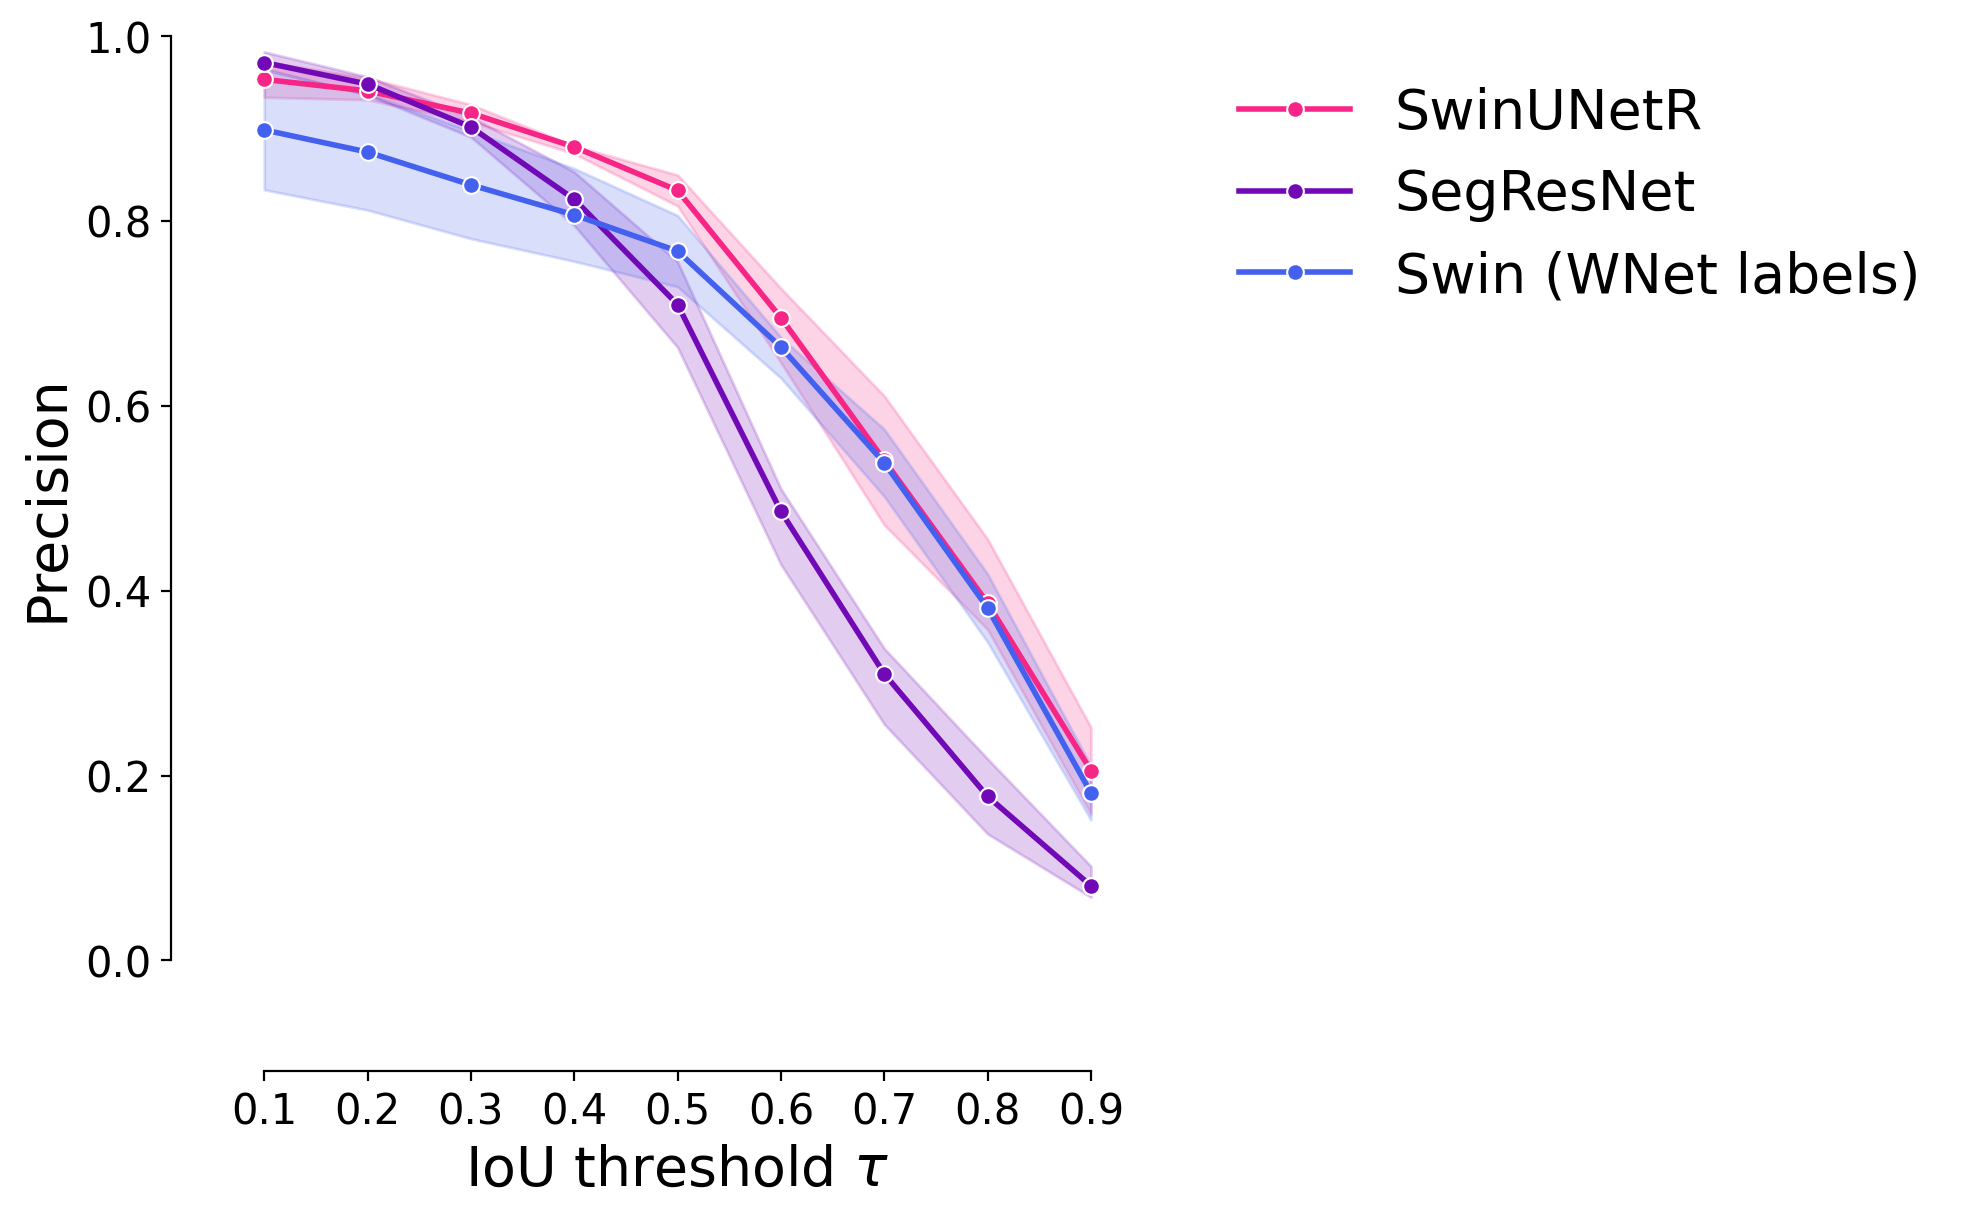

In [12]:
plot_stat_comparison_fold(df, stat="precision")
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "precision_comparison.png", bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "precision_comparison.svg", bbox_inches="tight")

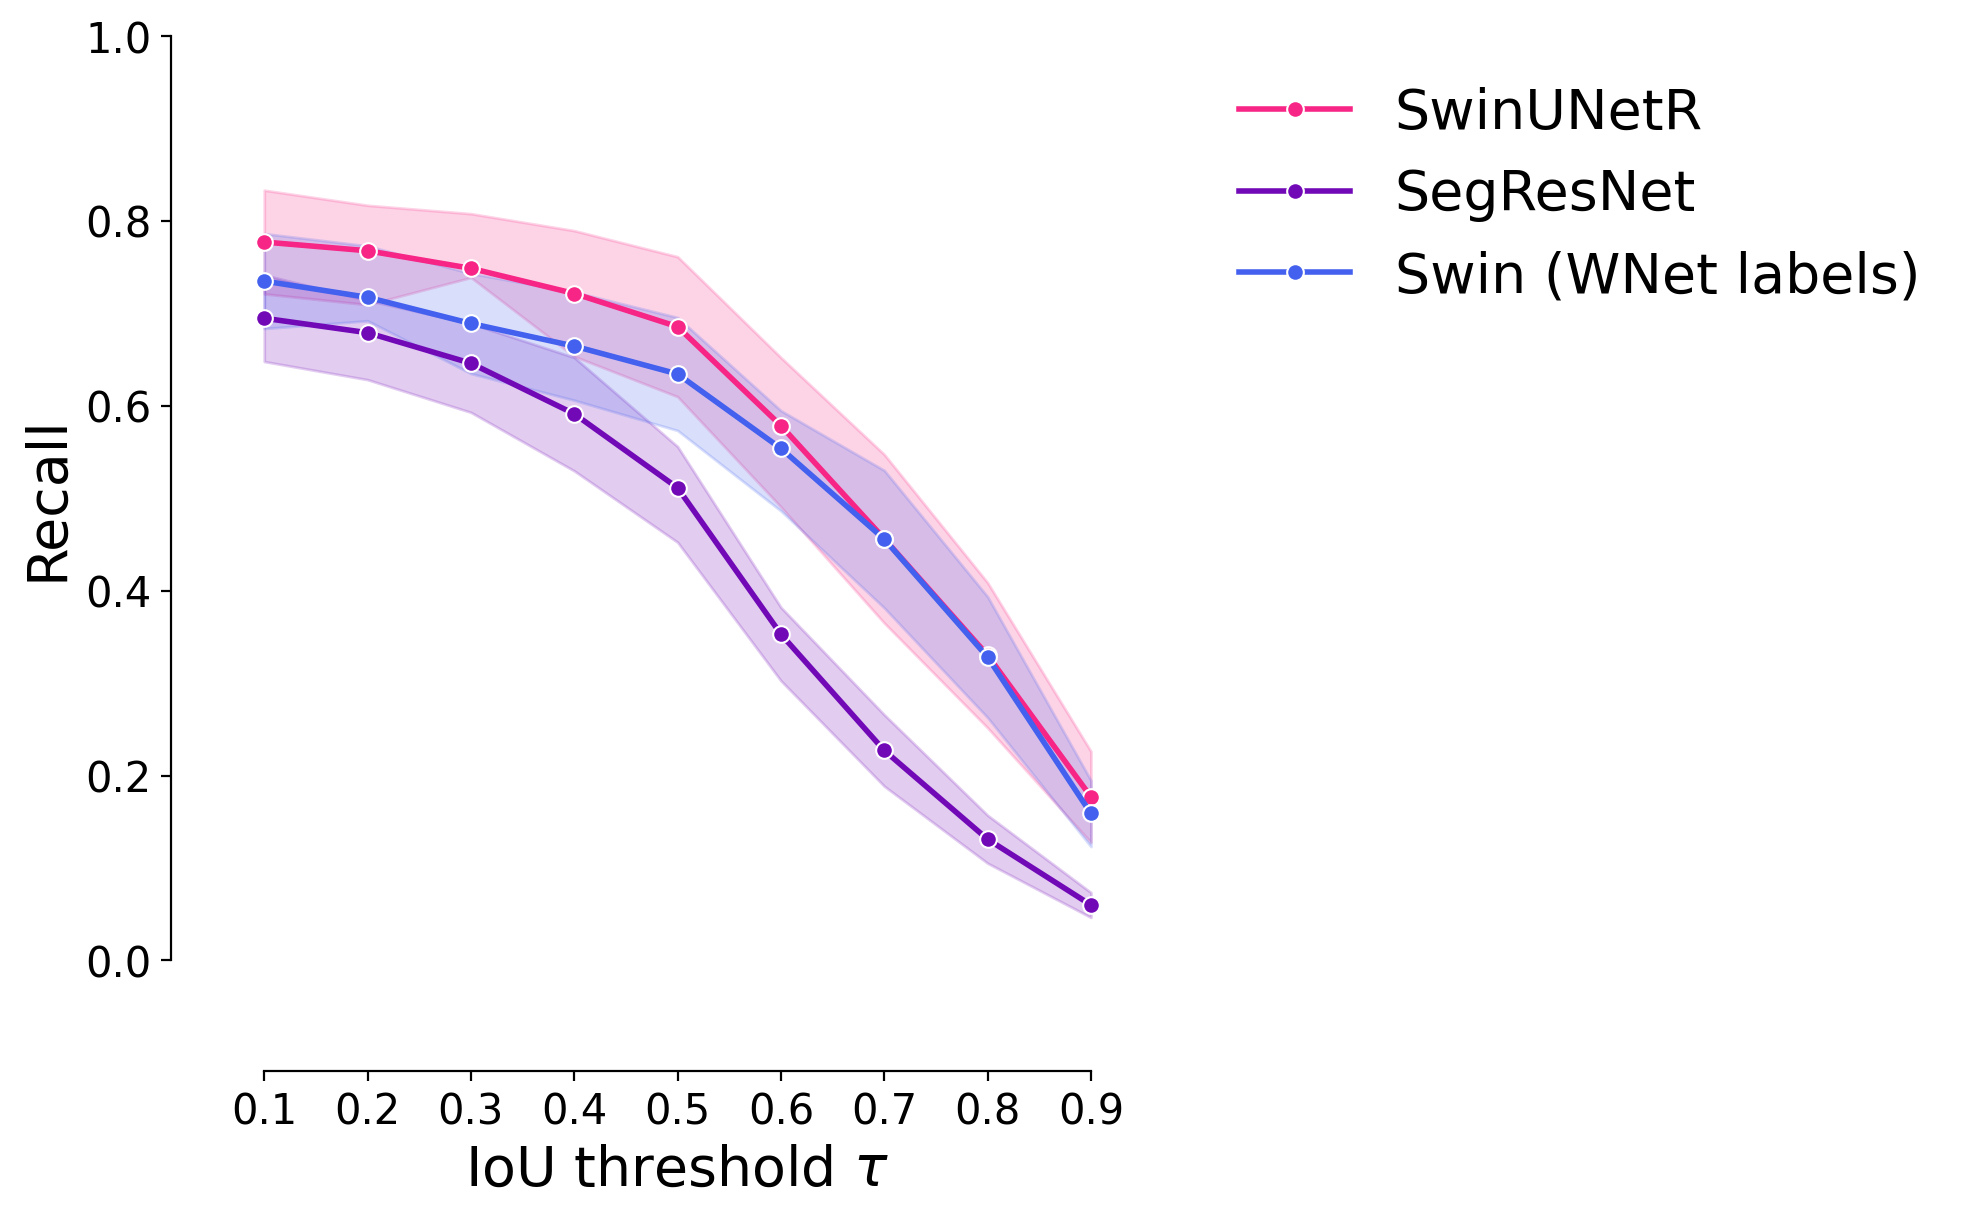

In [13]:
plot_stat_comparison_fold(df, stat="recall")
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "recall_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "recall_comparison.svg", bbox_inches="tight")

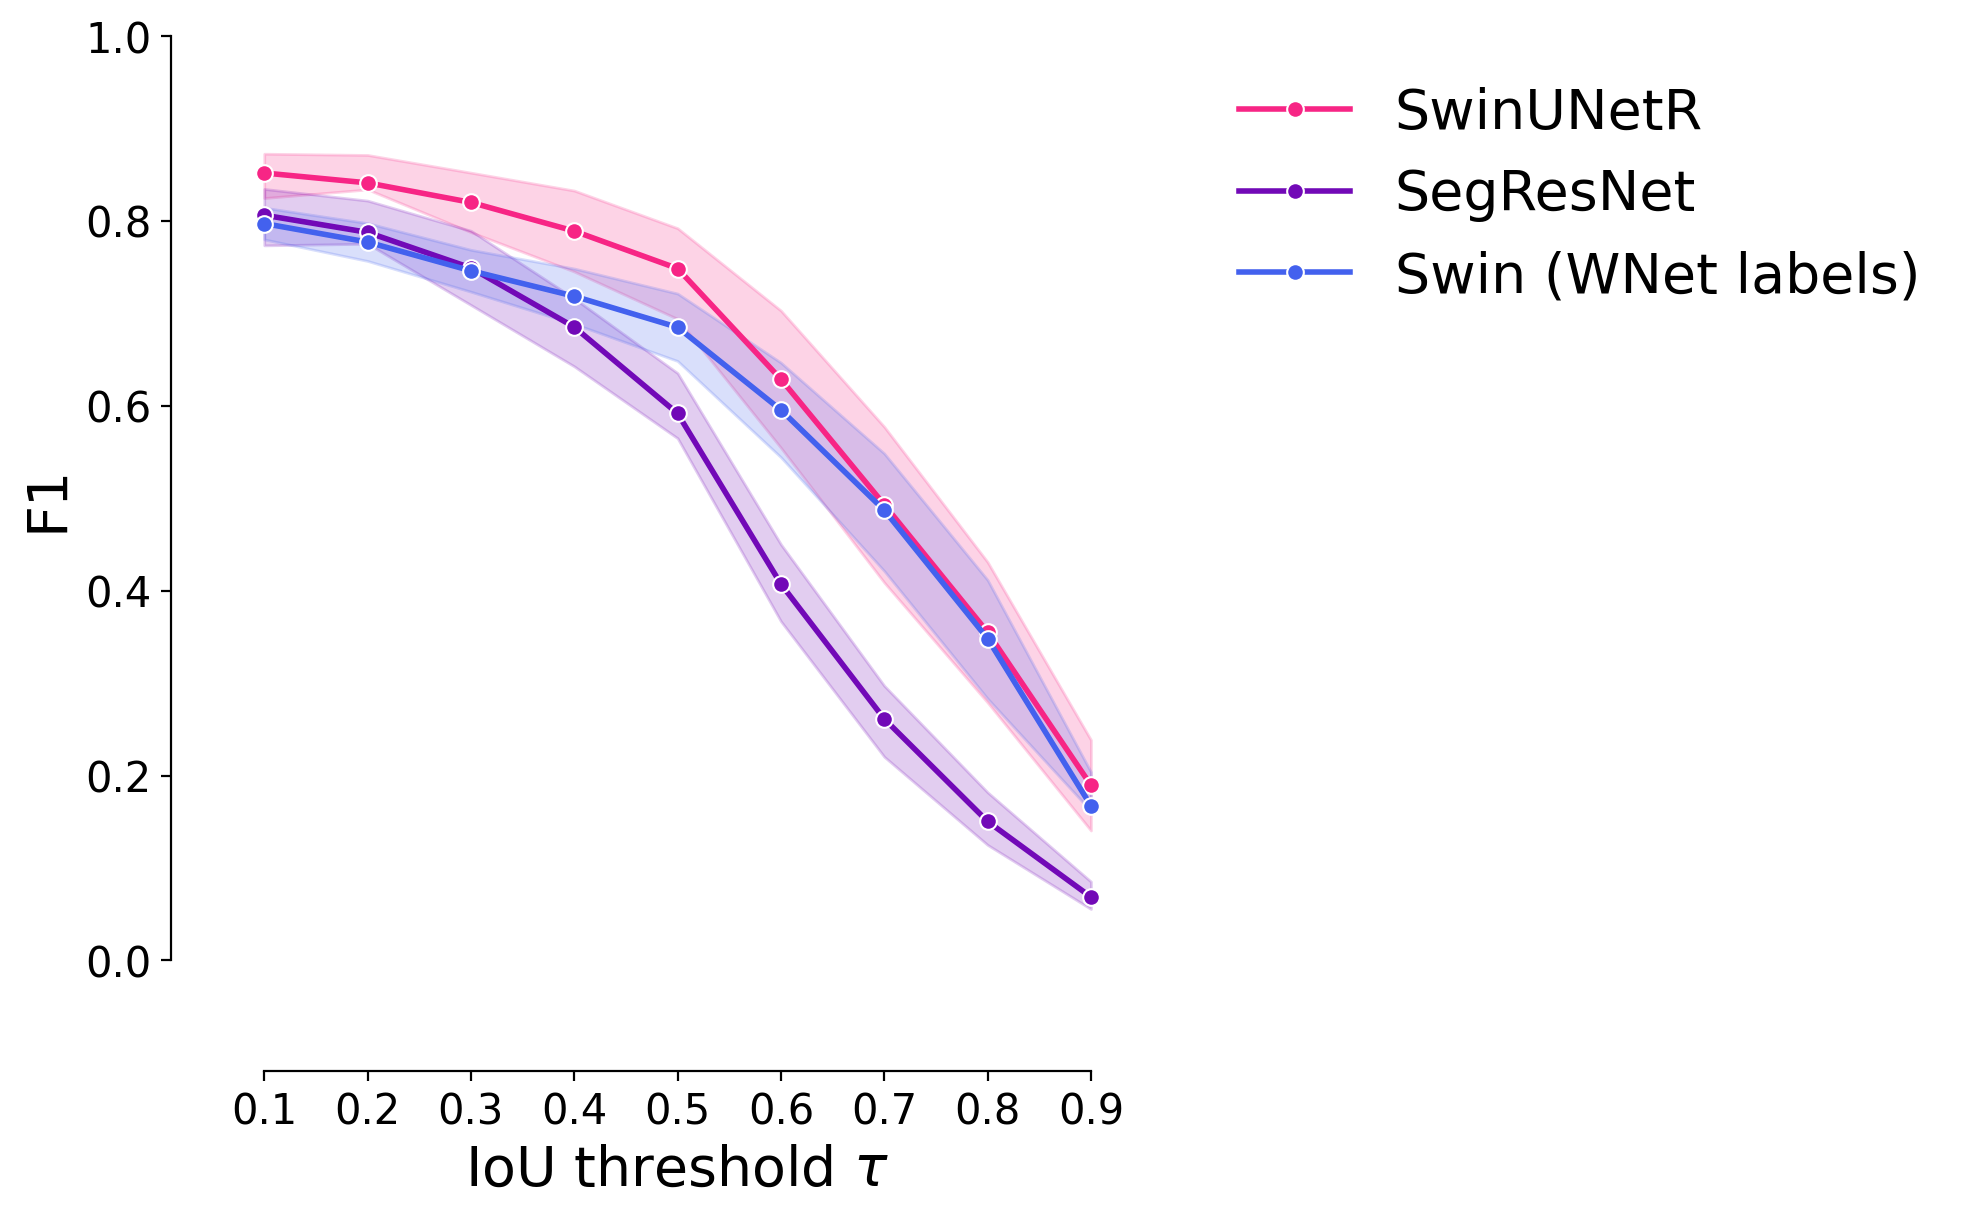

In [14]:
plot_stat_comparison_fold(df, stat="f1")
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "f1_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "f1_comparison.svg", bbox_inches="tight")

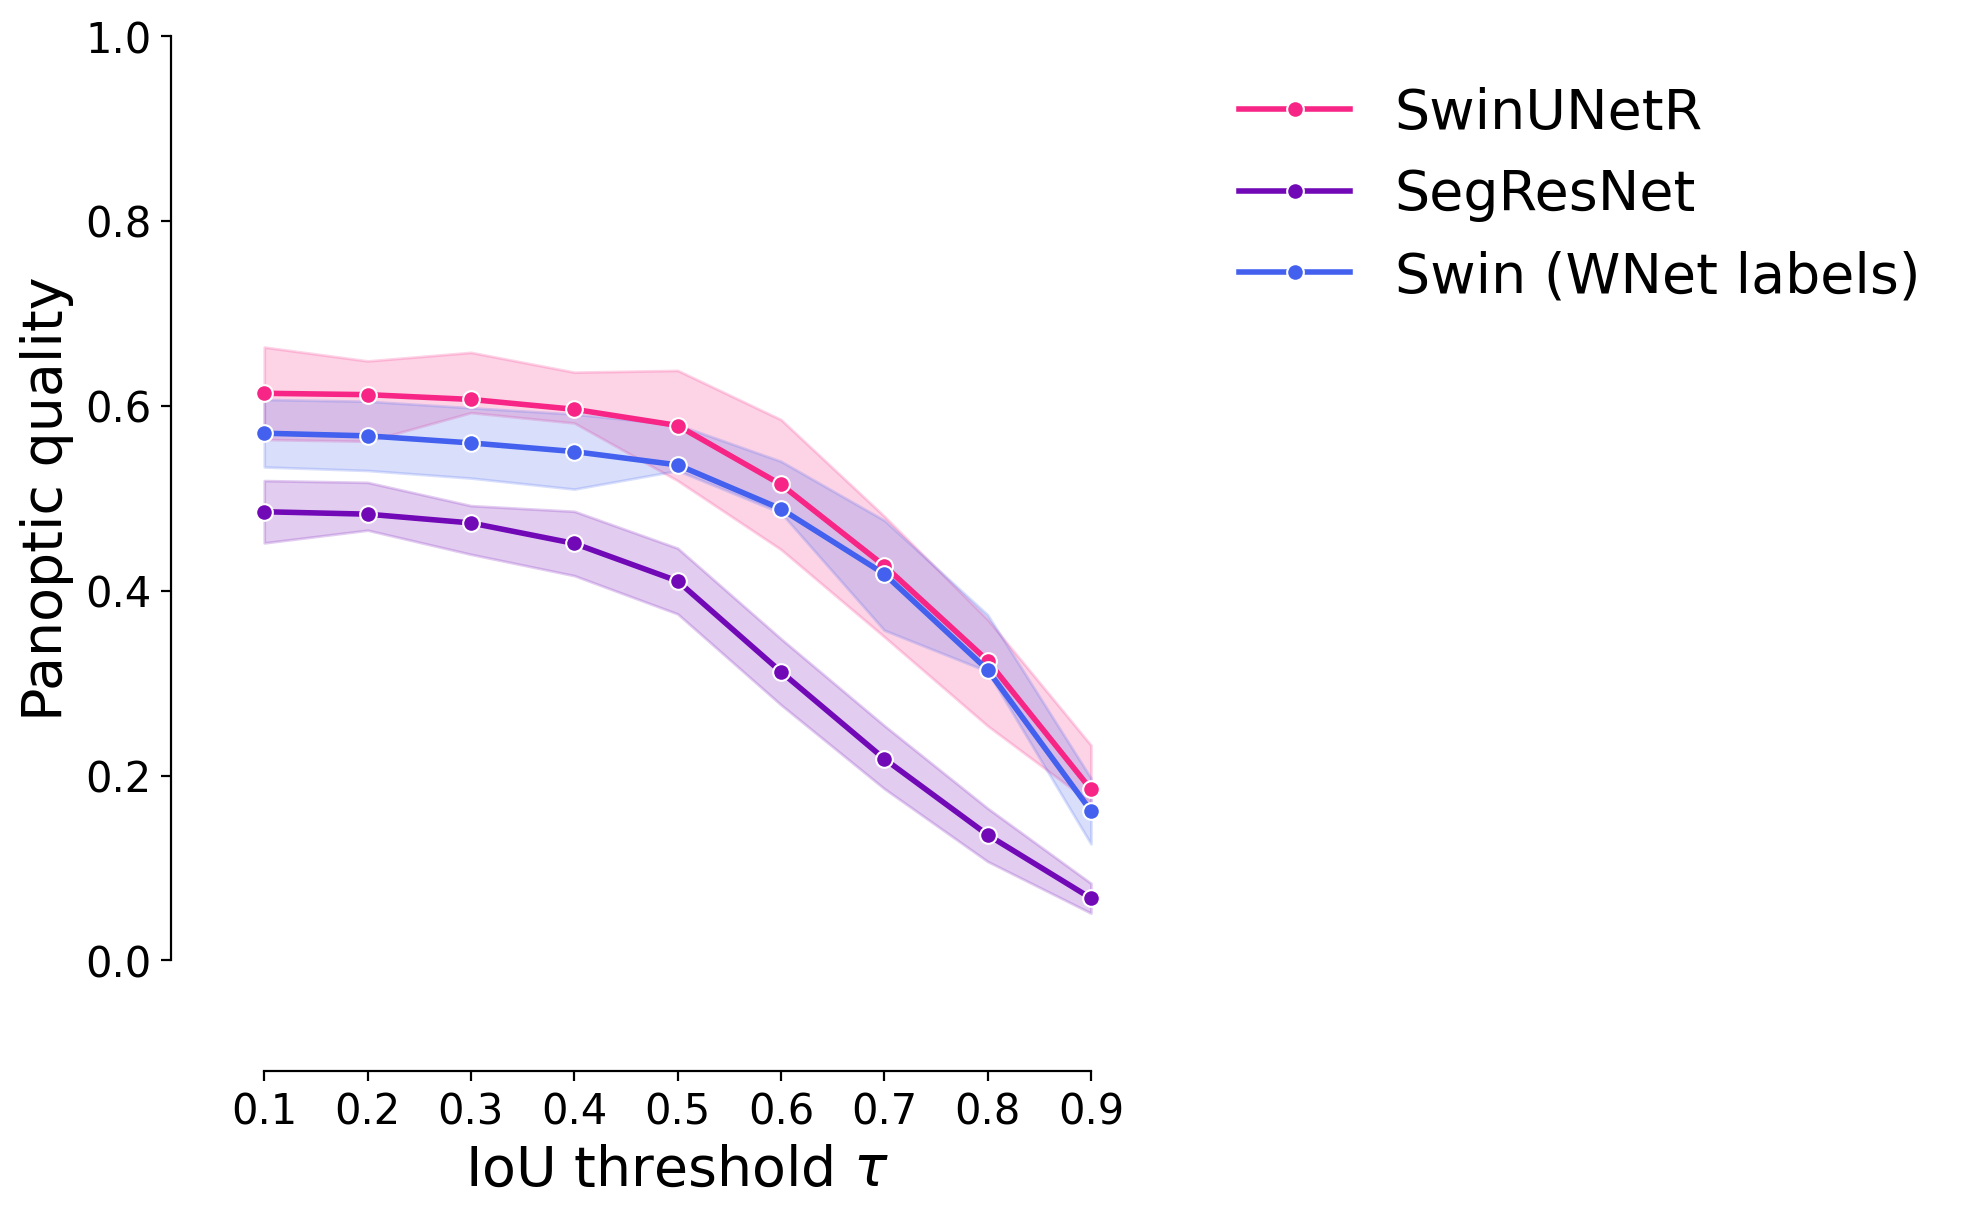

In [15]:
plot_stat_comparison_fold(df, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "panoptic_quality_comparison.svg", bbox_inches="tight")